In [3]:
%cd "~/code/snet/moses-incons-pen-xp"
%load_ext autoreload
%autoreload
%matplotlib inline

/home/xabush/code/snet/moses-incons-pen-xp
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import jax
import jax.random as rng
import jax.numpy as jnp
import numpyro as npyro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import daft
import arviz as az
import scipy
import scipy.stats as st
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from notebooks.variable_selection.MosesEstimator import *
from notebooks.variable_selection.util import *
from sklearn.model_selection import train_test_split, KFold
from scripts.samplers import *
import warnings
warnings.filterwarnings('ignore')

In [5]:
def logistic(x):
    return 1/(1 + jnp.exp(-x))

In [8]:
tamox_df = pd.read_csv("data/old_cancer_data/tamoxBinary.csv.xz")
tamox_df.describe()

,posOutcome,MAGEA12,MAGEA11,KLF1,ADH7,MSH4,BIRC3,AKR1C4,GBX2,GCGR,...,ZNF80,ZNF83,ZNF84,ZNF91,ZNHIT2,ZSCAN2,ZXDC,ZYX,ZZEF1,ZZZ3
count,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,...,642.000000,642.00000,642.00000,642.00000,642.000000,642.00000,642.00000,642.00000,642.000000,642.00000
mean,0.733645,0.225857,0.450156,0.255452,0.459502,0.367601,0.490654,0.311526,0.478193,0.481308,...,0.404984,0.50000,0.50000,0.50000,0.356698,0.50000,0.50000,0.50000,0.470405,0.50000
std,0.442397,0.418471,0.497897,0.436455,0.498746,0.482528,0.500302,0.463479,0.499914,0.500040,...,0.491272,0.50039,0.50039,0.50039,0.479398,0.50039,0.50039,0.50039,0.499513,0.50039
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.50000,0.50000,0.50000,0.000000,0.50000,0.50000,0.50000,0.000000,0.50000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.00000,1.00000,1.000000,1.00000,1.00000,1.00000,1.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.00000,1.00000,1.000000,1.00000,1.00000,1.00000,1.000000,1.00000


In [9]:
biogrid_net_df = pd.read_table("data/old_cancer_data/BIOGRID-ORGANISM-Homo_sapiens-4.4.211.tab3.txt")
biogrid_net_df.head()

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,Q59H94,NP_001120959|NP_001449,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1,117,84665,88,124185,106603,-,-,MYPN,ACTN2,CMD1DD|CMH22|MYOP|RCM4,...,Q59FD9|F6THM6,NP_001094|NP_001265272|NP_001265273,-,-,-,-,-,-,Homo sapiens,Homo sapiens
2,183,90,2339,106605,108625,-,-,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,...,-,NP_002018,-,-,-,-,-,-,Homo sapiens,Homo sapiens
3,278,2624,5371,108894,111384,-,-,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,-,NP_150250|NP_150253|NP_150252|NP_150247|NP_150...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
4,418,6118,6774,112038,112651,RP4-547C9.3,-,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,-,NP_644805|NP_003141|NP_001356447|NP_001356443|...,-,-,-,-,-,-,Homo sapiens,Homo sapiens


In [10]:
biogrid_net_df = biogrid_net_df.dropna(axis=0)
biogrid_net_df = biogrid_net_df[pd.to_numeric(biogrid_net_df["Entrez Gene Interactor A"], errors="coerce").notnull()]
biogrid_net_df = biogrid_net_df[pd.to_numeric(biogrid_net_df["Entrez Gene Interactor B"], errors="coerce").notnull()]
biogrid_net_df["Entrez Gene Interactor A"] = biogrid_net_df["Entrez Gene Interactor A"].astype(np.int)
biogrid_net_df["Entrez Gene Interactor B"] = biogrid_net_df["Entrez Gene Interactor B"].astype(np.int)
biogrid_net_df.head()

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,Q59H94,NP_001120959|NP_001449,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1,117,84665,88,124185,106603,-,-,MYPN,ACTN2,CMD1DD|CMH22|MYOP|RCM4,...,Q59FD9|F6THM6,NP_001094|NP_001265272|NP_001265273,-,-,-,-,-,-,Homo sapiens,Homo sapiens
2,183,90,2339,106605,108625,-,-,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,...,-,NP_002018,-,-,-,-,-,-,Homo sapiens,Homo sapiens
3,278,2624,5371,108894,111384,-,-,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,-,NP_150250|NP_150253|NP_150252|NP_150247|NP_150...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
4,418,6118,6774,112038,112651,RP4-547C9.3,-,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,-,NP_644805|NP_003141|NP_001356447|NP_001356443|...,-,-,-,-,-,-,Homo sapiens,Homo sapiens


In [11]:
biogrid_net = pd.Series(biogrid_net_df["Entrez Gene Interactor B"].values, index=biogrid_net_df["Entrez Gene Interactor A"])

In [12]:
hgnc_gene_sym_df = pd.read_csv("data/old_cancer_data/hgncSymbolMap6jul22long.csv")
hgnc_gene_sym_df =  hgnc_gene_sym_df.dropna(axis=0)
hgnc_gene_sym_df["NCBI Gene ID"] = hgnc_gene_sym_df["NCBI Gene ID"].astype(np.int)
hgnc_gene_sym_df = hgnc_gene_sym_df.drop_duplicates("NCBI Gene ID")
gene_id_mapping = pd.Series(hgnc_gene_sym_df["NCBI Gene ID"].values, index=hgnc_gene_sym_df["Approved symbol"]).to_dict()
gene_id_rev_mapping = pd.Series(hgnc_gene_sym_df["alt"].values, index=hgnc_gene_sym_df["NCBI Gene ID"]).to_dict()

In [13]:
gene_syms = tamox_df.columns.tolist()
not_matched_syms = []
gene_ids = []
for gene in gene_syms:
    if gene in gene_id_mapping:
        gene_ids.append(gene_id_mapping[gene])
    else:
        not_matched_syms.append(gene)

print(len(gene_ids))

7342


In [14]:
hgnc_gene_sym_df

,Approved symbol,NCBI Gene ID,Ensembl gene ID,alt
0,A1BG-AS1,503538,ENSG00000268895,NCRNA00181
5,A1CF,29974,ENSG00000148584,ACF
11,A2M,2,ENSG00000175899,FWP007
15,A2ML1,144568,ENSG00000166535,CPAMD9
19,A2MP1,3,ENSG00000256069,A2MP
...,...,...,...,...
83726,ZXDC,79364,ENSG00000070476,MGC11349
83729,ZYG11A,440590,ENSG00000203995,ZYG11
83731,ZYG11B,79699,ENSG00000162378,ZYG11
83734,ZZEF1,23140,ENSG00000074755,KIAA0399


In [17]:
with open("data/old_cancer_data/not_matched_syms.txt", "w") as fp:
    for g in not_matched_syms:
        fp.write(f"{g}\n")

In [18]:
tamox_genes_df = tamox_df.drop(columns=not_matched_syms)
tamox_genes_df.columns = gene_ids

In [19]:
gene_intr_map = {}
not_intr_biogrid = []
for g in gene_ids:
    try:
        intr_genes = [biogrid_net.iloc[g].tolist()]
        gene_intr_map[g] = []
        for g2 in intr_genes:
            if g2 in gene_ids:
                gene_intr_map[g].append(g2)
    except IndexError:
        not_intr_biogrid.append(g)
        continue

print(len(gene_intr_map.keys()))
not_intr_biogrid

7340


[105375355, 100133941]

In [20]:
X_all, y_all = tamox_genes_df.to_numpy(), tamox_df["posOutcome"].to_numpy()
seed = 1234
np.random.seed(seed)
rng_key, rng_key_predict = rng.split(rng.PRNGKey(1234))
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.3, shuffle=True, stratify=y_all)
X_train_all.shape

(449, 7342)

In [21]:
X_df, y_df = tamox_genes_df, tamox_df["posOutcome"]
seed = 1234
np.random.seed(seed)
rng_key, rng_key_predict = rng.split(rng.PRNGKey(1234))
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.3, shuffle=True, stratify=y_df)
X_train_df.shape

(449, 7342)

In [22]:
from scipy.stats import fisher_exact

cols = X_train_df.columns

p_values = []

for gene in cols:
    table = pd.crosstab(y_train_df, X_train_df[gene]).to_numpy()
    _, p_val = fisher_exact(table, alternative="two-sided")
    p_values.append(p_val)

In [23]:
p_values = np.array(p_values)
idx_sig = np.argwhere(p_values < 0.01)
tamox_p_val_genes_df = X_train_df.iloc[:,idx_sig[:,0]]
gene_ids_p_vals = tamox_p_val_genes_df.columns.tolist()
X_train_df = tamox_p_val_genes_df
X_train_df.shape

(449, 551)

In [25]:
# X_test_df = X_test_df[X_train_df.columns]
X_train, X_test = X_train_df.to_numpy(), X_test_df.to_numpy()
y_train, y_test = y_train_df.to_numpy(), y_test_df.to_numpy()

In [43]:
erbb2_syms, estrogen_syms, tamox_path_syms = [], [], []
erbb2_ids, estrogen_ids, tamox_path_ids = [], [], []
with open("data/old_cancer_data/tamoxifen_pathway_syms.txt", "r") as fp:
    for g in fp.readlines():
        g = g.strip()
        if g in gene_id_mapping and         g in gene_syms:
            tamox_path_syms.append(g)
            tamox_path_ids.append(gene_id_mapping[g])

with open("data/old_cancer_data/erbb2_signalling.txt", "r") as fp:
    for g in fp.readlines():
        g = g.strip()
        if g in gene_id_mapping and g in gene_syms:
            erbb2_syms.append(g)
            erbb2_ids.append(gene_id_mapping[g])

with open("data/old_cancer_data/estrogen_signalling_syms.txt", "r") as fp:
    for g in fp.readlines():
        g = g.strip()
        if g in gene_id_mapping and g in gene_syms:
            estrogen_syms.append(g)
            estrogen_ids.append(gene_id_mapping[g])

print(f"Tamoxifen Path: {len(tamox_path_syms)}, ERRB2 Path: {len(erbb2_syms)}, Estrogen Path: {len(estrogen_syms)}")

tamox_intr = len(list(set(tamox_path_syms) & set(gene_syms)))
errb_intr = len(list(set(erbb2_syms) & set(gene_syms)))
estrogen_intr = len(list(set(estrogen_syms) & set(gene_syms)))

tamox_fisher_intr = len(list(set(tamox_path_ids) & set(gene_ids_p_vals)))
estrogen_fisher_intr = len(list(set(estrogen_ids) & set(gene_ids_p_vals)))
erbb2_fisher_intr = len(list(set(erbb2_ids) & set(gene_ids_p_vals)))

print(f"Tamoxifen-All intr: {tamox_intr}, ERBB2-All intr: {errb_intr}, Estrogen-All intr: {estrogen_intr}")
print(f"Tamoxifen-fisher intr: {tamox_fisher_intr}, ERBB2-fisher intr: {erbb2_fisher_intr}, Estrogen-fisher intr: {estrogen_fisher_intr}")

Tamoxifen Path: 6, ERRB2 Path: 33, Estrogen Path: 116
Tamoxifen-All intr: 6, ERBB2-All intr: 33, Estrogen-All intr: 116
Tamoxifen-fisher intr: 0, ERBB2-fisher intr: 1, Estrogen-fisher intr: 8


In [34]:
p = X_train_df.shape[1]
J = np.zeros((p, p))
cols = X_train_df.columns
for i, g1 in enumerate(cols):
    if g1 in gene_intr_map:
        for g2 in gene_intr_map[g1]:
            if g2 in cols:
                j = cols.get_loc(g2)
                J[i, j] = 1.0
                ## BIOGRID Interactions are not symmetric but add symmetry to ensure we are working with undirected graph
                J[j, i] = 1.0

np.count_nonzero(J)

54

In [44]:
from numpyro.infer import MCMC, MixedHMC, HMC
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam
from numpyro.distributions.transforms import AffineTransform

def gamma_energy(gamma, J, eta, mu):
    return 0.5*eta*jnp.dot(jnp.dot(gamma.T, J), gamma) - mu*jnp.sum(gamma)

def model(X, y, sigma, J, eta=1.0, mu=1.0):
    L = np.linalg.cholesky(sigma)
    z = npyro.sample('z', dist.Normal(np.zeros(p), 1))
    beta = npyro.deterministic('beta', L @ z)
    # beta = npyro.sample('beta', dist.MultivariateNormal(0, sigma))
    gamma = npyro.sample('gamma', dist.Bernoulli(np.full(X.shape[1], 0.5)))
    npyro.factor('gamma_lgp', gamma_energy(gamma, J, eta, mu))
    prob = npyro.deterministic("prob", jnp.dot(X, (beta)))
    # print(f"Probs: {prob.shape}")
    likelihood = npyro.sample("y", dist.Bernoulli(logits=prob),
                              obs=y)

# sigma = 0.3 * np.ones((p, p))
# np.fill_diagonal(sigma, 25)
#


In [60]:
kernel = MixedHMC(HMC(model), random_walk=False)
mcmc = MCMC(kernel, num_warmup=300, num_samples=1000, num_chains=3, progress_bar=True)
mcmc.run(rng_key, X_train, y_train, 25*np.identity(p), J, 1.0, 10.0)

sample: 100%|███████████████████████████| 1300/1300 [08:22<00:00,  2.58it/s, 551 steps of size 1.80e+32. acc. prob=0.94]


In [61]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      0.00      0.00      0.00      0.00      0.00       nan       nan
  gamma[1]      0.00      0.00      0.00      0.00      0.00       nan       nan
  gamma[2]      0.00      0.00      0.00      0.00      0.00       nan       nan
  gamma[3]      0.00      0.00      0.00      0.00      0.00       nan       nan
  gamma[4]      0.00      0.00      0.00      0.00      0.00       nan       nan
  gamma[5]      0.00      0.00      0.00      0.00      0.00       nan       nan
  gamma[6]      0.00      0.00      0.00      0.00      0.00       nan       nan
  gamma[7]      0.00      0.00      0.00      0.00      0.00       nan       nan
  gamma[8]      0.00      0.00      0.00      0.00      0.00       nan       nan
  gamma[9]      0.00      0.00      0.00      0.00      0.00       nan       nan
 gamma[10]      0.00      0.00      0.00      0.00      0.00       nan       nan
 gamma[11]      0.00      0

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

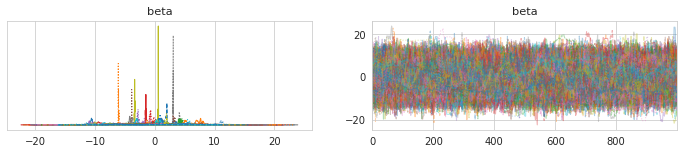

In [62]:
import arviz as az
infr_data = az.from_numpyro(mcmc)
az.plot_trace(infr_data, var_names=["beta"])

In [109]:
gamma_samples = jax.device_get(mcmc.get_samples(group_by_chain=True)["gamma"][np.array([0,2])])
beta_samples = jax.device_get(mcmc.get_samples(group_by_chain=True)["beta"][np.array([0,2])])
gamma_samples = gamma_samples.reshape(gamma_samples.shape[0]*gamma_samples.shape[1], gamma_samples.shape[2])
beta_samples = beta_samples.reshape(beta_samples.shape[0]*beta_samples.shape[1], beta_samples.shape[2])
jnp.save("data/np_data/gamma_samples_nb_tamox_1.npy", gamma_samples)
jnp.save("data/np_data/beta_samples_nb_tamox_1.npy", beta_samples)

In [9]:
gamma_samples = jnp.load("data/np_data/gamma_samples_nb_tamox_1.npy")
beta_samples = jnp.load("data/np_data/beta_samples_nb_tamox_1.npy")

In [10]:
gamma_samples.shape

(2000, 551)

In [35]:
feats_1_eng_idx, feats_1_eng = rank_hmc_feats_eng(gamma_samples, beta_samples, X_train, y_train, J, 1.0, 10.0)

In [11]:
np.quantile(np.mean(gamma_samples, axis=0), q=[0, 0.25, 0.5, 0.75, 1.0])

array([0. , 0. , 0. , 0. , 0.5])

In [12]:
np.quantile(np.abs(np.mean(beta_samples, axis=0)), q=[0, 0.25, 0.5, 0.75, 1.0])

array([7.25979859e-04, 2.28697293e-01, 5.54844499e-01, 1.14520741e+00,
       6.28318262e+00])

In [41]:
pred_mean = np.mean(gamma_samples, axis=0)
nonzero_c = np.count_nonzero(pred_mean)
ar = np.arange(p)
# cond = np.logical_and(np.mean(gamma_samples, axis=0) > 0, np.ones(p))
cond = np.abs(np.mean(beta_samples, axis=0)) > 2
# f_idx = np.argsort(np.mean(gamma_samples, axis=0))[::-1][:nonzero_c]
f_idx = ar[cond]
len(f_idx)

80

In [33]:
# Using features selected by MCMC
res_log_df = run_fs_logreg(X_train, X_test, y_train, y_test, 1234, [f_idx])
res_log_df

100%|███████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it, l_tr=0.75, l_te=0.71]


,log_cv_score,log_test_score
0,0.751665,0.706849


In [395]:
# all features

res_log_df = run_fs_logreg(X_train_all, X_test_all, y_train_all, y_test_all, 1234, [list(np.arange(tamox_genes_df.shape[1]))])
res_log_df

100%|███████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.02s/it, l_tr=0.76, l_te=0.72]


,log_cv_score,log_test_score
0,0.756039,0.724524


In [396]:
# Using all features with p < 0.01 - 551 features
print(f"p: {p}")
res_log_df = run_fs_logreg(X_train, X_test, y_train, y_test, 1234, [list(np.arange(p))])
res_log_df

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

p: 551


100%|███████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it, l_tr=0.80, l_te=0.71]


,log_cv_score,log_test_score
0,0.798394,0.71182


In [483]:
res_moses_df = run_fs_moses(X_train, X_test, y_train, y_test, 1234, [f_idx])
res_moses_df

100%|█████████████████████████████████████████| 1/1 [00:38<00:00, 38.77s/it, m_tr=0.65, m_te=0.53, l_tr=0.70, l_te=0.65]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.646114,0.531345,0.697873,0.653065


In [ ]:
kernel_2 = MixedHMC(HMC(model), random_walk=False)
mcmc_2 = MCMC(kernel_2, num_warmup=300, num_samples=1000, num_chains=3, progress_bar=True)
mcmc_2.run(rng_key, X_train, y_train, 25*np.identity(p), J, 1.0, 1.0)

warmup:   1%|▏                        | 7/1300 [38:11<238:05:10, 662.88s/it, 1517254 steps of size 2.69e-07. acc. prob=0.00]

In [173]:
mcmc_2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      0.20      0.40      0.00      0.00      1.00    248.47      1.02
  gamma[1]      0.20      0.40      0.00      0.00      1.00    676.78      1.00
  gamma[2]      0.20      0.40      0.00      0.00      1.00    397.83      1.00
  gamma[3]      0.26      0.44      0.00      0.00      1.00    318.07      1.01
  gamma[4]      0.31      0.46      0.00      0.00      1.00    230.73      1.01
  gamma[5]      0.27      0.44      0.00      0.00      1.00    266.49      1.00
  gamma[6]      0.37      0.48      0.00      0.00      1.00    152.51      1.00
  gamma[7]      0.19      0.39      0.00      0.00      1.00    363.48      1.00
  gamma[8]      0.19      0.39      0.00      0.00      1.00    510.17      1.00
  gamma[9]      0.22      0.42      0.00      0.00      1.00    227.50      1.03
 gamma[10]      0.21      0.41      0.00      0.00      1.00    393.00      1.00
 gamma[11]      0.23      0

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

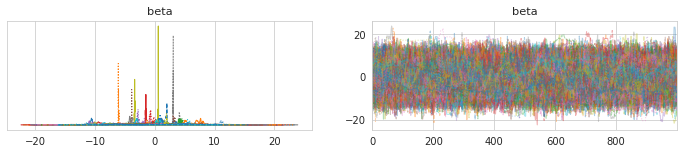

In [174]:
import arviz as az
infr_data = az.from_numpyro(mcmc)
az.plot_trace(infr_data, var_names=["beta"])

In [363]:
gamma_samples_2 = jax.device_get(mcmc_2.get_samples()["gamma"])
beta_samples_2 = jax.device_get(mcmc_2.get_samples()["beta"])
jnp.save("data/np_data/gamma_samples_2_nb_tamox_1.npy", gamma_samples_2)
jnp.save("data/np_data/beta_samples_nb_2_tamox_1.npy", beta_samples_2)

In [310]:
np.quantile(np.abs(np.mean(beta_samples_2, axis=0)), q=[0, 0.25, 0.5, 0.75, 1.0])

array([1.15604303e-03, 2.26644322e-01, 4.65066135e-01, 1.08008850e+00,
       7.89794779e+00])

In [309]:
np.quantile(np.mean(gamma_samples_2, axis=0), q=[0, 0.25, 0.5, 0.75, 1.0])

array([0.12533333, 0.18916667, 0.23333333, 0.3145    , 0.964     ])

In [494]:
ar = np.arange(p)
f_idx_2 = ar[np.logical_and(np.mean(gamma_samples_2, axis=0) > 0.3, np.abs(np.mean(beta_samples_2, axis=0)) > 1.5)]
# f_idx_2 = ar[np.abs(np.mean(beta_samples_2, axis=0)) > 1.5]
len(f_idx_2)

92

In [495]:
res_log_df = run_fs_logreg(X_train, X_test, y_train, y_test, 1234, [f_idx_2])
res_log_df

100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s, l_tr=0.97, l_te=0.73]


,log_cv_score,log_test_score
0,0.973778,0.730599


In [353]:
run_fs_moses(X_train, X_test, y_train, y_test, 1234, [f_idx_2])

100%|█████████████████████████████████████████| 1/1 [00:56<00:00, 56.50s/it, m_tr=0.64, m_te=0.63, l_tr=0.88, l_te=0.63]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.642749,0.628141,0.884779,0.626139


In [49]:
J_sqr = (J @ J @ J) + (J @ J) + J
J_sqr[J_sqr > 0] = 1.0
np.fill_diagonal(J_sqr, 0.0)
np.count_nonzero(J_sqr)

60

In [40]:
np.count_nonzero(np.diag(J_sqr))

0

In [ ]:
kernel_3 = MixedHMC(HMC(model), random_walk=False)
mcmc_3 = MCMC(kernel_3, num_warmup=300, num_samples=1000, num_chains=3, progress_bar=True)
mcmc_3.run(rng_key, X_train, y_train, 25*np.identity(p), J_sqr, 1.0, 1.0)

sample: 100%|████████████████████████| 1300/1300 [12:21:53<00:00, 34.24s/it, 998 steps of size 8.99e-03. acc. prob=0.88]


In [46]:
J_control = np.zeros((p, p))

In [ ]:
kernel_4 = MixedHMC(HMC(model), random_walk=False)
mcmc_4 = MCMC(kernel_4, num_warmup=300, num_samples=1000, num_chains=3, progress_bar=True)
mcmc_4.run(rng_key, X_train, y_train, 25*np.identity(p), J_control, 1.0, 1.0)

sample: 100%|███████████████████████████| 1300/1300 [12:39<00:00,  1.71it/s, 998 steps of size 8.99e-03. acc. prob=0.88]


In [398]:
gamma_samples_3 = jax.device_get(mcmc_3.get_samples()["gamma"])
beta_samples_3 = jax.device_get(mcmc_3.get_samples()["beta"])
jnp.save("data/np_data/gamma_samples_3_nb_tamox_1.npy", gamma_samples)
jnp.save("data/np_data/beta_samples_nb_3_tamox_1.npy", beta_samples)

In [399]:
mcmc_3.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      0.19      0.39      0.00      0.00      1.00    336.05      1.00
  gamma[1]      0.18      0.38      0.00      0.00      1.00    527.28      1.01
  gamma[2]      0.23      0.42      0.00      0.00      1.00    349.89      1.01
  gamma[3]      0.27      0.44      0.00      0.00      1.00    332.58      1.00
  gamma[4]      0.26      0.44      0.00      0.00      1.00    352.11      1.01
  gamma[5]      0.22      0.42      0.00      0.00      1.00    192.84      1.02
  gamma[6]      0.38      0.49      0.00      0.00      1.00    184.29      1.02
  gamma[7]      0.18      0.38      0.00      0.00      1.00    524.72      1.01
  gamma[8]      0.18      0.38      0.00      0.00      1.00    398.30      1.01
  gamma[9]      0.25      0.43      0.00      0.00      1.00    237.03      1.01
 gamma[10]      0.17      0.37      0.00      0.00      1.00    394.45      1.01
 gamma[11]      0.22      0

In [425]:
np.quantile(np.abs(np.mean(beta_samples_3, axis=0)), q=[0, 0.25, 0.5, 0.75, 1.0])

array([5.36423235e-04, 2.17308074e-01, 5.46263337e-01, 1.25437230e+00,
       8.20107841e+00])

In [426]:
np.quantile(np.mean(gamma_samples_3, axis=0), q=[0, 0.25, 0.5, 0.75, 1.0])

array([0.13233333, 0.19166667, 0.237     , 0.31466667, 0.98766667])

In [442]:
ar = np.arange(p)
f_idx_3 = ar[np.logical_and(np.mean(gamma_samples_3, axis=0) > 0.3, np.abs(np.mean(beta_samples_3, axis=0)) > 1.5)]
# f_idx_3 = ar[np.abs(np.mean(beta_samples_3, axis=0)) > 1.25]
len(f_idx_3)

105

In [443]:
run_fs_logreg(X_train, X_test, y_train, y_test, 1234, [f_idx_3])

100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s, l_tr=0.97, l_te=0.72]


,log_cv_score,log_test_score
0,0.972413,0.717343


In [461]:
run_fs_moses(X_train, X_test, y_train, y_test, 1234, [f_idx_3])

100%|█████████████████████████████████████████| 1/1 [01:12<00:00, 72.79s/it, m_tr=0.62, m_te=0.62, l_tr=0.89, l_te=0.66]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.62021,0.622618,0.885513,0.659832


In [422]:
mcmc_4.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      0.21      0.41      0.00      0.00      1.00    273.45      1.01
  gamma[1]      0.20      0.40      0.00      0.00      1.00    599.61      1.01
  gamma[2]      0.24      0.43      0.00      0.00      1.00    302.72      1.01
  gamma[3]      0.24      0.43      0.00      0.00      1.00    206.16      1.01
  gamma[4]      0.16      0.37      0.00      0.00      1.00    411.81      1.01
  gamma[5]      0.27      0.44      0.00      0.00      1.00    201.16      1.02
  gamma[6]      0.46      0.50      0.00      0.00      1.00    117.44      1.03
  gamma[7]      0.17      0.37      0.00      0.00      1.00    341.26      1.00
  gamma[8]      0.19      0.39      0.00      0.00      1.00    450.06      1.00
  gamma[9]      0.22      0.41      0.00      0.00      1.00    253.66      1.01
 gamma[10]      0.17      0.37      0.00      0.00      1.00    355.53      1.02
 gamma[11]      0.18      0

In [444]:
gamma_samples_4 = jax.device_get(mcmc_4.get_samples()["gamma"])
beta_samples_4 = jax.device_get(mcmc_4.get_samples()["beta"])
jnp.save("data/np_data/gamma_samples_4_nb_tamox_1.npy", gamma_samples)
jnp.save("data/np_data/beta_samples_nb_4_tamox_1.npy", beta_samples)

In [445]:
np.quantile(np.abs(np.mean(beta_samples_4, axis=0)), q=[0, 0.25, 0.5, 0.75, 1.0])

array([4.04585531e-04, 2.26693481e-01, 5.22069633e-01, 1.06156248e+00,
       7.82432556e+00])

In [446]:
np.quantile(np.mean(gamma_samples_4, axis=0), q=[0, 0.25, 0.5, 0.75, 1.0])

array([0.131     , 0.18666667, 0.21966667, 0.30016667, 0.98      ])

In [496]:
ar = np.arange(p)
f_idx_4 = ar[np.logical_and(np.mean(gamma_samples_4, axis=0) > 0.3, np.abs(np.mean(beta_samples_4, axis=0)) > 1.5)]
# f_idx_4 = ar[np.abs(np.mean(beta_samples_4, axis=0)) > 0.5]
len(f_idx_4)

92

In [497]:
run_fs_logreg(X_train, X_test, y_train, y_test, 1234, [f_idx_4])

100%|███████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it, l_tr=0.97, l_te=0.72]


,log_cv_score,log_test_score
0,0.968353,0.716101


In [460]:
run_fs_moses(X_train, X_test, y_train, y_test, 1234, [f_idx_4])

100%|█████████████████████████████████████████| 1/1 [01:13<00:00, 73.03s/it, m_tr=0.67, m_te=0.64, l_tr=0.87, l_te=0.67]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.669112,0.641466,0.874575,0.669635


In [53]:
from numpyro.infer import NUTS
kernel_5 = NUTS(model)
mcmc_5 = MCMC(kernel_5, num_warmup=300, num_samples=1000, num_chains=3, progress_bar=True)
mcmc_5.run(rng_key, X_train, y_train, 25*np.identity(p), J_control, 1.0, 1.0)

warmup:   5%|█▎                        | 63/1300 [07:50<2:34:06,  7.47s/it, 1023 steps of size 4.58e-03. acc. prob=0.74]


KeyboardInterrupt: 

In [48]:
X_train.shape

(449, 551)